In [1]:
# Pandas dataframe
import pandas as pd
from pandas import DataFrame

# Scikit-Learn
import sklearn 
from sklearn import datasets, linear_model, metrics, tree
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score

# Models
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import (BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, 
RandomForestRegressor, AdaBoostRegressor)
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
        
import joblib
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [2]:
df_em = pd.read_csv("dataset_scaled_em.csv")

In [3]:
#Checks the column names, and ensures that they do not have any leading or trailing spaces
df_em.columns = df_em.columns.str.strip()

In [4]:
# Input for ML models

input_col = ['in_amount_mmol', 'p_amount_mmol', 'ligand_amount_mmol', 'first_sol_amount_ml', 'second_sol_amount_ml', 
             'third_sol_amount_ml', 'other_1_amount_mmol', 'other_2_amount_mmol', 'total_volume_ml', 
             'temp_c', 'time_min', 'x0_chloroindium oxalate', 'x0_indium acetate', 'x0_indium bromide', 
             'x0_indium chloride', 'x0_indium iodide', 'x0_indium myristate', 'x0_indium oxalate', 
             'x0_indium palmitate', 'x0_indium trifluoroacetate', 'x0_indium tris(N,N-diisopropylacetamidinato)', 
             'x1_bis(trimethylsilyl)phosphine', 'x1_phosphine gas', 'x1_phosphorus trichloride', 'x1_sodium phosphide', 
             'x1_tris(diethylamino)phosphine', 'x1_tris(dimethylamino)phosphine', 'x1_tris(trimethylgermyl)phosphine', 
             'x1_tris(trimethylsilyl)phosphine', 'x1_white phosphorus', 'x2_None', 'x2_dodecanethiol', 
             'x2_lauric acid', 'x2_myristic acid', 'x2_oleic acid', 'x2_palmitic acid', 'x2_stearic acid', 
             'x3_4-ethylpyridine', 'x3_None', 'x3_dimethylformamide', 'x3_dodecylamine', 'x3_mesitylene', 
             'x3_octadecene', 'x3_oleylamine', 'x3_trioctylamine', 'x3_trioctylphosphine', 'x3_trioctylphosphine oxide', 
             'x4_None', 'x4_dioctyl ether', 'x4_dioctylamine', 'x4_hexadecylamine', 'x4_hexadecylamine', 
             'x4_octylamine', 'x4_oleylamine', 'x4_toluene', 'x4_trioctylphosphine', 'x4_trioctylphosphine oxide', 
             'x5_None', 'x5_trioctylphosphine', 'x6_None', 'x6_acetic acid', 'x6_superhydride', 
             'x6_tetrabutylammonium myristate', 'x6_zinc acetate', 'x6_zinc bromide', 'x6_zinc chloride', 
             'x6_zinc iodide', 'x6_zinc octanoate', 'x6_zinc oleate', 'x6_zinc stearate', 'x6_zinc undecylenate', 
             'x7_None', 'x7_copper bromide', 'x7_oleic acid', 'x7_water', 'x7_zinc iodide']

output_col = ['emission_nm']

X = df_em[input_col]

Y = df_em[output_col]

In [5]:
# Splitting dataset for training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=45, shuffle=True)

# Hyper parameter tuning
## Ensemble regressors

### Bagging

In [9]:
%%time

#sklearn random search over n iterations
#define ranges of paramaters to tune
#the internet tunes these parameters for bagging

params = {'n_estimators': range(10,1001)}

#n_jobs runs jobs in parallel, verbose prints updates in command line
rs_bag = RandomizedSearchCV(BaggingRegressor(), param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_bag.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_bag.best_score_)
print('Best Parameters : ',rs_bag.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -35.956
Best Parameters :  {'n_estimators': 23}
CPU times: user 2.61 s, sys: 142 ms, total: 2.75 s
Wall time: 4min 7s


In [42]:
%%time

#sklearn random search over n iterations
#define ranges of paramaters to tune
#the internet tunes these parameters for bagging

params = {'random_state': range(1,1001)}

#n_jobs runs jobs in parallel, verbose prints updates in command line
rs_bag = RandomizedSearchCV(BaggingRegressor(n_estimators=23), param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_bag.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_bag.best_score_)
print('Best Parameters : ',rs_bag.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -35.812
Best Parameters :  {'random_state': 972}
CPU times: user 1.56 s, sys: 153 ms, total: 1.71 s
Wall time: 14.1 s


Mean absolute error = 30.046 nm


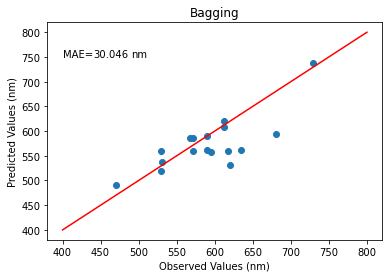

In [46]:
#using random search parameters
B_regr = BaggingRegressor(n_estimators=23)
B_regr.fit(X_train, np.ravel(Y_train))
            
B_Y_pred = B_regr.predict(X_test)
            
B_mae = mean_absolute_error(Y_test, B_Y_pred)
print("Mean absolute error =", round(B_mae,3), 'nm')

plt.figure()
plt.title("Bagging")
plt.plot(Y_test, B_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(B_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Random Forest

In [11]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_rf.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_rf.best_score_)
print('Best Parameters : ',rs_rf.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -36.386
Best Parameters :  {'n_estimators': 162}
CPU times: user 3.51 s, sys: 161 ms, total: 3.67 s
Wall time: 4min 10s


In [47]:
%%time

#sklearn random search

params = {'random_state': range(1,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_rf = RandomizedSearchCV(RandomForestRegressor(n_estimators=162), param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_rf.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_rf.best_score_)
print('Best Parameters : ',rs_rf.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -36.214
Best Parameters :  {'random_state': 13}
CPU times: user 2.69 s, sys: 182 ms, total: 2.88 s
Wall time: 1min 3s


Mean absolute error = 31.319 nm


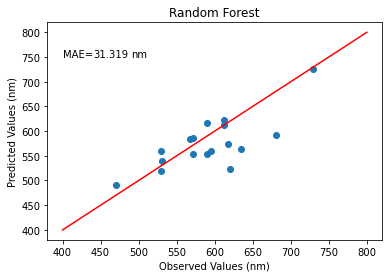

In [48]:
#using grid search parameters
RF_regr = RandomForestRegressor(n_estimators=162)
RF_regr.fit(X_train, np.ravel(Y_train))
            
RF_Y_pred = RF_regr.predict(X_test)
            
RF_mae = mean_absolute_error(Y_test, RF_Y_pred)
print("Mean absolute error =", round(RF_mae,3), 'nm')

plt.figure()
plt.title("Random Forest")
plt.plot(Y_test, RF_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(RF_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Decision Tree

In [17]:
%%time

#sklearn random search

params = {'min_samples_split': range(2,100),
          'min_samples_leaf':range(1,100)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_dt = RandomizedSearchCV(DecisionTreeRegressor(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_dt.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_dt.best_score_)
print('Best Parameters : ',rs_dt.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -41.751
Best Parameters :  {'min_samples_split': 20, 'min_samples_leaf': 3}
CPU times: user 2.99 s, sys: 118 ms, total: 3.11 s
Wall time: 8.68 s


Mean absolute error = 41.991 nm


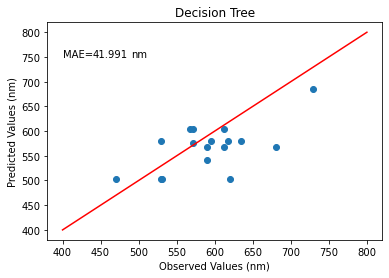

In [18]:
#using grid search parameters
DT_regr = DecisionTreeRegressor(min_samples_leaf=3, min_samples_split=20)
DT_regr.fit(X_train, np.ravel(Y_train))
            
DT_Y_pred = DT_regr.predict(X_test)
            
DT_mae = mean_absolute_error(Y_test, DT_Y_pred)
print("Mean absolute error =", round(DT_mae,3), 'nm')

plt.figure()
plt.title("Decision Tree")
plt.plot(Y_test, DT_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(DT_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Extra Trees

In [7]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001),
          'min_samples_split':range(2,10),
         'min_samples_leaf': range(1,10)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_et = RandomizedSearchCV(ExtraTreesRegressor(), param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_et.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_et.best_score_)
print('Best Parameters : ',rs_et.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [43]:
%%time

#after first optimisation, now looking for best random state

params = {'random_state':range(1,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_et = RandomizedSearchCV(ExtraTreesRegressor(n_estimators=361, min_samples_split=5, min_samples_leaf=5), 
                           param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_et.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_et.best_score_)
print('Best Parameters : ',rs_et.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -38.013
Best Parameters :  {'random_state': 193}
CPU times: user 3.36 s, sys: 218 ms, total: 3.57 s
Wall time: 1min 44s


Mean absolute error = 32.292 nm


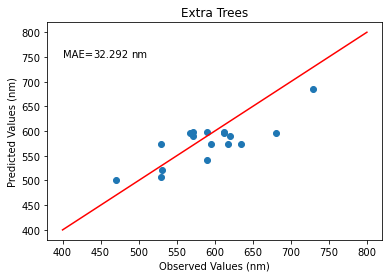

In [23]:
ET_regr = ExtraTreesRegressor(n_estimators=361, min_samples_split=5, min_samples_leaf=5)
            
ET_regr.fit(X_train, np.ravel(Y_train))
            
ET_Y_pred = ET_regr.predict(X_test)
            
ET_mae = mean_absolute_error(Y_test, ET_Y_pred)
print("Mean absolute error =", round(ET_mae,3), 'nm')

plt.figure()
plt.title("Extra Trees")
plt.plot(Y_test, ET_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(ET_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Ada Boost

In [22]:
%%time

#sklearn random search

params = {'n_estimators': range(50,501),
          'learning_rate':range(1,11),
         'loss':['linear', 'square', 'exponential']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_ab = RandomizedSearchCV(AdaBoostRegressor(), param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_ab.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_ab.best_score_)
print('Best Parameters : ',rs_ab.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -38.730
Best Parameters :  {'n_estimators': 189, 'loss': 'exponential', 'learning_rate': 4}
CPU times: user 2.79 s, sys: 73.9 ms, total: 2.86 s
Wall time: 1min 16s


Mean absolute error = 36.087 nm


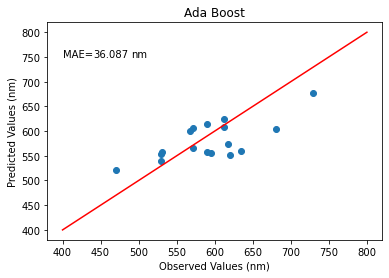

In [26]:
AB_regr = AdaBoostRegressor(n_estimators=189, loss='exponential', learning_rate=4)
            
AB_regr.fit(X_train, np.ravel(Y_train))
AB_Y_pred = AB_regr.predict(X_test)
            
AB_mae = mean_absolute_error(Y_test, AB_Y_pred)
print("Mean absolute error =", round(AB_mae,3), 'nm')

plt.figure()
plt.title("Ada Boost")
plt.plot(Y_test, AB_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(AB_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Gradient Boosting

In [24]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001),
          'min_samples_split':range(2,21),
         'min_samples_leaf': range(1,11),
         'max_depth':range(3,31)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_gb = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_gb.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_gb.best_score_)
print('Best Parameters : ',rs_gb.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -36.105
Best Parameters :  {'n_estimators': 838, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_depth': 24}
CPU times: user 3.74 s, sys: 85.9 ms, total: 3.82 s
Wall time: 1min 13s


Mean absolute error = 34.978 nm


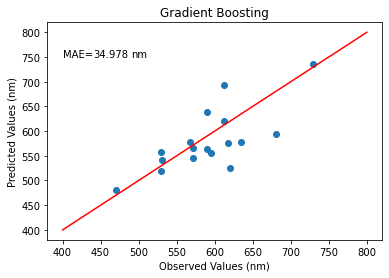

In [29]:
GB_regr = GradientBoostingRegressor(n_estimators=838, min_samples_split=15, min_samples_leaf=4, max_depth=24)
            
GB_regr.fit(X_train, np.ravel(Y_train))
GB_Y_pred = GB_regr.predict(X_test)
            
GB_mae = mean_absolute_error(Y_test, GB_Y_pred)
print("Mean absolute error =", round(GB_mae,3), 'nm')

plt.figure()
plt.title("Gradient Boosting")
plt.plot(Y_test, GB_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(GB_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

## Others

### Linear Regression

Mean absolute error = 104.911 nm


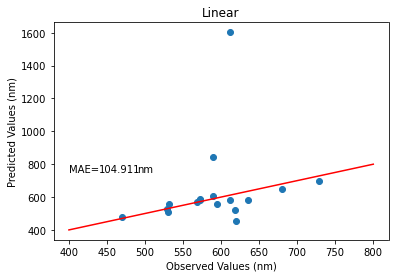

In [26]:
#using random search parameters
Linear_regr = LinearRegression()
Linear_regr.fit(X_train, np.ravel(Y_train))
            
Linear_Y_pred = Linear_regr.predict(X_test)
            
Linear_mae = mean_absolute_error(Y_test, Linear_Y_pred)
print("Mean absolute error =", round(Linear_mae,3), 'nm')

plt.figure()
plt.title("Linear")
plt.plot(Y_test, Linear_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Linear_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Lasso

In [27]:
%%time

#sklearn random search over n iterations

params = {'max_iter': range(1000,10001),
         'selection': ['cyclic', 'random']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_lasso = RandomizedSearchCV(Lasso(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_lasso.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_lasso.best_score_)
print('Best Parameters : ',rs_lasso.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -35.598
Best Parameters :  {'selection': 'random', 'max_iter': 3220}
CPU times: user 2.81 s, sys: 165 ms, total: 2.97 s
Wall time: 9.39 s


In [45]:
%%time

#sklearn random search over n iterations

params = {'random_state':range(1,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_lasso = RandomizedSearchCV(Lasso(selection='random', max_iter=3220), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_lasso.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_lasso.best_score_)
print('Best Parameters : ',rs_lasso.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -35.600
Best Parameters :  {'random_state': 576}
CPU times: user 2.58 s, sys: 115 ms, total: 2.69 s
Wall time: 8.82 s


Mean absolute error = 32.029 nm


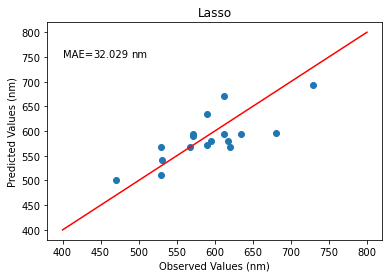

In [33]:
#using random search parameters
Lasso_regr = Lasso(selection='random', max_iter=3220)
Lasso_regr.fit(X_train, np.ravel(Y_train))
            
Lasso_Y_pred = Lasso_regr.predict(X_test)
            
Lasso_mae = mean_absolute_error(Y_test, Lasso_Y_pred)
print("Mean absolute error =", round(Lasso_mae,3), 'nm')

plt.figure()
plt.title("Lasso")
plt.plot(Y_test, Lasso_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Lasso_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### ElasticNet

In [29]:
%%time

#sklearn random search over n iterations

params = {'max_iter': range(1000,10001),
         'selection': ['cyclic', 'random']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_en = RandomizedSearchCV(ElasticNet(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_en.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_en.best_score_)
print('Best Parameters : ',rs_en.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -44.843
Best Parameters :  {'selection': 'random', 'max_iter': 3584}
CPU times: user 2.86 s, sys: 91.6 ms, total: 2.95 s
Wall time: 9.12 s


Mean absolute error = 37.783 nm


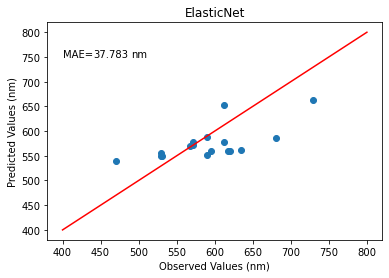

In [35]:
#using random search parameters
EN_regr = ElasticNet(selection='random', max_iter=3584)
EN_regr.fit(X_train, np.ravel(Y_train))
            
EN_Y_pred = EN_regr.predict(X_test)
            
EN_mae = mean_absolute_error(Y_test, EN_Y_pred)
print("Mean absolute error =", round(EN_mae,3), 'nm')

plt.figure()
plt.title("ElasticNet")
plt.plot(Y_test, EN_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(EN_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Ridge

In [50]:
%%time

#sklearn random search over n iterations

params = {'max_iter':range(1000,10001),
         'random_state':range(1,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_ridge = RandomizedSearchCV(Ridge(solver='saga'), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_ridge.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_ridge.best_score_)
print('Best Parameters : ',rs_ridge.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -39.795
Best Parameters :  {'random_state': 918, 'max_iter': 9513}
CPU times: user 2.66 s, sys: 132 ms, total: 2.8 s
Wall time: 22.5 s


Mean absolute error = 29.478 nm


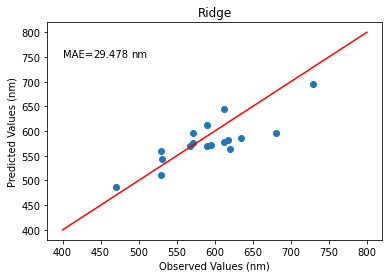

In [39]:
#using random search parameters
Ridge_regr = Ridge(solver='saga', max_iter=9513)
Ridge_regr.fit(X_train, np.ravel(Y_train))
            
Ridge_Y_pred = Ridge_regr.predict(X_test)
            
Ridge_mae = mean_absolute_error(Y_test, Ridge_Y_pred)
print("Mean absolute error =", round(Ridge_mae,3), 'nm')

plt.figure()
plt.title("Ridge")
plt.plot(Y_test, Ridge_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Ridge_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### SVR kernel='linear'

In [35]:
%%time

#sklearn random search over n iterations

params = {'degree':range(1,10),
         'cache_size':range(200,2001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_svrlin = RandomizedSearchCV(SVR(kernel='linear'), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_svrlin.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_svrlin.best_score_)
print('Best Parameters : ',rs_svrlin.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -45.799
Best Parameters :  {'degree': 9, 'cache_size': 1306}
CPU times: user 2.94 s, sys: 106 ms, total: 3.05 s
Wall time: 9.49 s


Mean absolute error = 38.808 nm


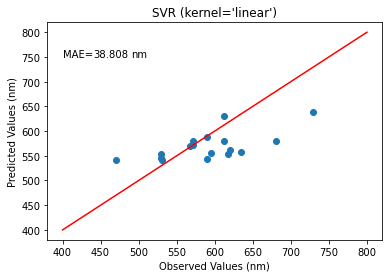

In [41]:
#using random search parameters
SVRlin_regr = SVR(kernel='linear', degree=9, cache_size=1306)
SVRlin_regr.fit(X_train, np.ravel(Y_train))
            
SVRlin_Y_pred = SVRlin_regr.predict(X_test)
            
SVRlin_mae = mean_absolute_error(Y_test, SVRlin_Y_pred)
print("Mean absolute error =", round(SVRlin_mae,3), 'nm')

plt.figure()
plt.title("SVR (kernel='linear')")
plt.plot(Y_test, SVRlin_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(SVRlin_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### SVR kernel='rbf'

In [37]:
%%time

#sklearn random search over n iterations

params = {'degree':range(1,10),
         'cache_size':range(200,2001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_svrrbf = RandomizedSearchCV(SVR(kernel='rbf'), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_svrrbf.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_svrrbf.best_score_)
print('Best Parameters : ',rs_svrrbf.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -49.573
Best Parameters :  {'degree': 2, 'cache_size': 938}
CPU times: user 2.84 s, sys: 77.4 ms, total: 2.92 s
Wall time: 9.7 s


Mean absolute error = 51.912 nm


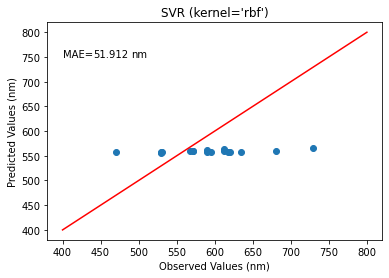

In [38]:
#using random search parameters
SVRrbf_regr = SVR(kernel='rbf', degree=2, cache_size=938)
SVRrbf_regr.fit(X_train, np.ravel(Y_train))
            
SVRrbf_Y_pred = SVRrbf_regr.predict(X_test)
            
SVRrbf_mae = mean_absolute_error(Y_test, SVRrbf_Y_pred)
print("Mean absolute error =", round(SVRrbf_mae,3), 'nm')

plt.figure()
plt.title("SVR (kernel='rbf')")
plt.plot(Y_test, SVRrbf_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(SVRrbf_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

## Conclusion

Ridge gave the best performance, **solver='saga', max_iter=9513, random_state=918**

## Saving model

In [52]:
Ridge_regr = Ridge(solver='saga', max_iter=9513, random_state=918)

Ridge_regr.fit(X_train, np.ravel(Y_train))
Ridge_Y_pred = Ridge_regr.predict(X_test)

joblib.dump(Ridge_regr, "./model_aug_em_Ridge.joblib")

['./model_aug_em_Ridge.joblib']